# Anticipez les besoins en consommations de bâtiments

## Étape 4 : Comparez plusieurs modèles supervisés

### Reprendre les éléments de notre notebook de l'étape 3

* J'importe les librairies nécessaires

In [1]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate, 
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

#Librairies de base et notre fichier de l'étape 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
building_clean_def = pd.read_csv("../Data/Projet_3_etape3_clean.csv")

* Petit récapitulatif

In [2]:
data_avant_transformation = building_clean_def.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')

Nous retrouvons 1601 lignes et nous avons 48 colonnes avant le nettoyage des données avant transformation.


## Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).

### Recommendation 1 : Privilégier l'utilisation de la méthode cross_validate, déjà importée au début de la section modélisation du notebook template et regarder la documentation de scikit-learn sur cette méthode afin de bien l'adapter à votre usage.
### Recommendation 2 : Commencer par un modèle linéaire, car il sera plus facile à comprendre.

#### Analyse de la distribution de notre valeur cible, la consommation totale d'énergie

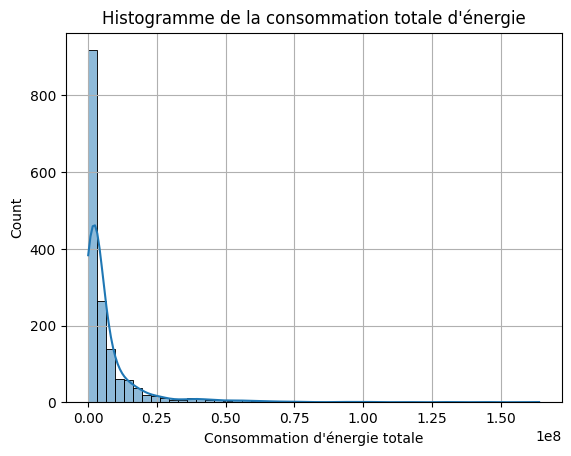

In [3]:
sns.histplot(building_clean_def["SiteEnergyUse(kBtu)"], bins=50, kde=True)
plt.title("Histogramme de la consommation totale d'énergie")
plt.xlabel("Consommation d'énergie totale")
plt.grid()

* On voit qu'il y a un étalement sur la droite.


#### Dans la recommendation il est indiqué d'utiliser la fonction de cross validate. Nous allons également le faire mais dans un premier temps nous allons faire un test train split, pour prendre en mains les différentes méthodes.

### Avec un test train split sans cross validate

#### On commence par la régression linéaire de scikit-learn

* On enregistre notre modèle de régression linéaire

In [4]:
reg = LinearRegression()

In [5]:
building_clean_def.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 48 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   NumberofBuildings                               1601 non-null   float64
 1   NumberofFloors                                  1601 non-null   int64  
 2   PropertyGFATotal                                1601 non-null   int64  
 3   PropertyGFAParking                              1601 non-null   int64  
 4   SiteEnergyUse(kBtu)                             1601 non-null   float64
 5   HasSteam                                        1601 non-null   int64  
 6   HasElectricity                                  1601 non-null   int64  
 7   HasGas                                          1601 non-null   int64  
 8   NbSourcesEnergies                               1601 non-null   int64  
 9   SecondUseRatio                           

#### On va scinder notre dataset en une partie d'entraînement et une partie d'évaluation en utilisant la fonction train_test_split de scikit-learn.

#### Séparation du jeu de données en jeu d’apprentissage et jeu de test. On fixe 20% pour les données test et 80% pour l'entraînement. Après avoir séparé le jeu avec le train test split on peut standardiser nos variables. Par contre on doit enlever les variables que nous avons déjà encodées

#### J'enregsitre les colonnes à standardiser et celles qui ne doivent pas changer

In [6]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']
encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]

* Vérification du nombre de colonnes que j'enregistre. J'en ai une de moins, ce qui est normal c'est ma target

In [7]:
len(numerical_cols)+ len(encoded_cols)

47

#### Je sépare mon jeu de données et je standardise les éléments numériques non encodés

In [8]:
# Colonnes encodées et des colonnes numériques
numerical_cols # à scaler
encoded_cols # OneHot, Binaire, déjà OK

# Séparation X / y
y = building_clean_def["SiteEnergyUse(kBtu)"]
X = building_clean_def.drop(columns=["SiteEnergyUse(kBtu)"])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Je définis ma varibale StandardScaler et je fais le scaling seulement sur les colonnes numériques
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_num = scaler.transform(X_test[numerical_cols])

# On recompose dans un DataFrame le X_train et X_test
X_train_scaled = pd.concat([
    pd.DataFrame(X_train_scaled_num, columns=numerical_cols, index=X_train.index),
    X_train[encoded_cols]
], axis=1)

X_test_scaled = pd.concat([
    pd.DataFrame(X_test_scaled_num, columns=numerical_cols, index=X_test.index),
    X_test[encoded_cols]
], axis=1)

* Je vérifie si le scaling a fonctionné

In [9]:
X_train_scaled

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,NbSourcesEnergies,SecondUseRatio,ThirdUseRatio,AreaPerFloor,HasSteam,HasElectricity,...,Neighborhood_GREATER_DUWAMISH,Neighborhood_LAKE_UNION,Neighborhood_MAGNOLIA_QUEENANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,UsageType_Bin,AgeGroup
628,-0.082379,-0.327957,-0.485981,-0.306847,-1.606843,-0.662636,-0.348773,-0.398618,0,1,...,0,0,0,1,0,0,0,0,1,3
693,-0.082379,-0.169846,-0.440352,-0.306847,-1.606843,0.171100,-0.348773,-0.412013,0,1,...,0,0,0,0,1,0,0,0,1,3
705,-0.082379,-0.327957,-0.372505,-0.306847,0.425528,2.056722,-0.348773,-0.238885,0,1,...,1,0,0,0,0,0,0,0,1,1
497,-0.082379,0.304487,0.022551,-0.306847,0.425528,0.111210,-0.348773,-0.272438,0,1,...,0,0,0,0,0,0,0,0,1,3
1169,-0.082379,-0.486067,-0.462558,-0.306847,0.425528,0.820066,-0.348773,-0.164031,0,1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.082379,-0.486067,-0.409169,-0.306847,0.425528,1.751252,1.791662,-0.013727,0,1,...,1,0,0,0,0,0,0,0,1,2
1294,-0.082379,-0.169846,-0.481861,-0.306847,0.425528,-0.716638,-0.348773,-0.450967,0,1,...,0,0,0,0,0,0,0,0,0,3
860,-0.082379,-0.486067,0.263900,-0.306847,0.425528,-0.716638,-0.348773,1.881149,0,1,...,0,0,1,0,0,0,0,0,0,2
1459,-0.082379,-0.486067,0.007111,-0.306847,0.425528,-0.716638,-0.348773,1.158216,0,1,...,0,0,0,0,0,0,0,0,0,2


#### On entraîne le modèle

#### On commence par un modèle de régression linéaire
* C’est un modèle qui prédit une valeur continue (y) à partir de une ou plusieurs variables explicatives (x1, x2, ...). On l’entraîne sur des données connues pour apprendre les coefficients. Ensuite, on peut prédire y pour de nouvelles données.


#### J'entraîne le modèle

In [10]:
reg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Pour estimer la performance sur le sous-ensemble de test, il faut tout d'abord obtenir les prédictions pour  X_test

In [11]:
y_pred = reg.predict(X_test_scaled)

#### On peut maintenant calculer l'écart entre les vraies valeurs de test  (y_test)  et celles prédites par le modèle. Utilisons la RMSE/ MAE/ MAPE et R2 comme scores. Pour les 4 premières métriques, un score plus petit correspond à un meilleur modèle. C'est l'inverse pour R2, le coefficient de détermination. A noter que RMSE n'est pas contrainte.

In [13]:
# Calcul des scores de performances
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error (y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

RMSE: 8716220.678022157
MAE: 3826606.753194855
MAPE: 1.2563542361864737
R2: 0.4856188731316242


Petite définitions des scores de performance :
* RMSE (Root Mean Squared Error) : Erreur quadratique moyenne. Ça mesure l’écart moyen entre les prédictions et la réalité, en donnant plus de poids aux grosses erreurs. Plus c’est bas, mieux c’est.
* MAE (Mean Absolute Error) : Erreur absolue moyenne. C’est l’écart moyen, sans mettre de poids supplémentaire aux grosses erreurs. Plus c’est bas, mieux c’est.
* MAPE (Mean Absolute Percentage Error) : Erreur moyenne en pourcentage. Même principe que le MAE, mais en % de la valeur réelle.
* R2(coefficient de détermination) : Mesure quelle proportion de la variance des données est expliquée par ton modèle. 1 = parfait, 0 = pas mieux que prédire la moyenne, négatif = pire que la moyenne.

Interprétation des scores :
* RMSE : En moyenne, les prédictions s’écartent de la vraie valeur d’environ 8,7 millions. C'est beaucoup mais il ne faut pas oublier que notre target est la consommation d'énergie (grosse valeur)
* MAE : L'erreur absolue moyenne est aussi  élevée, le modèle se trompe en moyenne de 3,8 millions.
* MAPE : Les prédictions sont en moyenne à 125% de la valeur réelle.
* R2 : moins de 50% est expliquée par le modèle

Nous ne sommes pas dans une distribution normale, ce qui peut expliquer ces résultats.

### Refactoring : Utilisons la même démarche que ci-dessus mais en pouvant changer de modèle facilement

#### Création d'une fonction pour pouvoir changer de modèle

In [14]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]
# Création de la fonction et je fige mes conditions
def modelisation(model, building_clean_def, target_col="SiteEnergyUse(kBtu)", test_size=0.2, random_state=42):
    y = building_clean_def[target_col]
    X = building_clean_def.drop(columns=[target_col])

# Test en jeu d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

# Standardisation de nos varibales non encodées
    scaler = StandardScaler()
    X_train_scaled_num = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled_num = scaler.transform(X_test[numerical_cols])

# Je reconstitue un nouveau dataframe
    X_train_scaled = pd.concat([
        pd.DataFrame(X_train_scaled_num, columns=numerical_cols, index=X_train.index),
        X_train[encoded_cols]
    ], axis=1)

    X_test_scaled = pd.concat([
        pd.DataFrame(X_test_scaled_num, columns=numerical_cols, index=X_test.index),
        X_test[encoded_cols]
    ], axis=1)


# J'entraîne le modèle
    model.fit(X_train_scaled, y_train)
   
    # Prédictions
    y_pred = model.predict(X_test_scaled)

# Calcul des indicateurs de performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    print(f"Modèle : {model.__class__.__name__}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE : {mape:.4f}")
    print(f"R² : {r2:.4f}")

    return model, rmse, mape

In [15]:
# Analyse déjà effectuée
modelisation(LinearRegression(), building_clean_def)

Modèle : LinearRegression
RMSE : 8716220.68
MAE : 3826606.7532
MAPE : 1.2564
R² : 0.4856


(LinearRegression(), np.float64(8716220.678022157), 1.2563542361864737)

#### Modèle Dummyregressor

Le DummyRegressor est un modèle de "base" (ou "naïf") qui ne fait aucune analyse intelligente des données. Il sert de référence pour comparer avec d’autres modèles plus complexes.

In [16]:
modelisation(DummyRegressor(), building_clean_def)

Modèle : DummyRegressor
RMSE : 12158403.64
MAE : 6912971.8060
MAPE : 3.5900
R² : -0.0009


(DummyRegressor(), np.float64(12158403.635978049), 3.5899776112902697)

Interprétation des scores :
* RMSE : En moyenne, le modèle se trompe de 12,2 millions sur ses prédictions.
* MAE : L’erreur moyenne absolue est de 6,9 millions : c’est l’écart moyen entre la prédiction (la moyenne) et la vraie valeur.
* MAPE : En moyenne, l’erreur représente 359% de la vraie valeur. Cela signifie que prédire la moyenne est imprécis, car la cible varie énormément.
* R2 négatif : Le modèle n'est pas bon.

Prédire la moyenne donne une erreur énorme, ce qui suggère que les valeurs de la cible sont très dispersées. Mais nous avons ici des données de consommation d'énergie, ce qui peut expliquer ces écarts énormes.

#### Modèle SVR
* Le SVR est une variante des machines à vecteurs de support (SVM) adaptée à la régression. Contrairement à la régression linéaire, il ne cherche pas à minimiser l’erreur quadratique moyenne, mais à trouver une fonction qui reste à l’intérieur d’une "marge" (ε) autour des données, en tolérant un certain nombre d’erreurs.

In [17]:
modelisation(SVR(), building_clean_def)

Modèle : SVR
RMSE : 13090921.04
MAE : 5962279.2733
MAPE : 1.2056
R² : -0.1603


(SVR(), np.float64(13090921.037988363), 1.2056106795023986)

Interprétation des scores :
* RMSE : L’erreur quadratique moyenne est de 13,1 millions. C’est une amélioration par rapport aux précédents modèles, mais reste élevée en valeur absolue.
* MAE : L’erreur absolue moyenne est de 6 millions. C’est l’erreur moyenne.
* MAPE : En moyenne, les prédictions s’écartent de 120% de la valeur réelle. Encore très elevé.
* R2 négtaif : le modèle n'est pas bon

Le modèle n'est pas bon.

#### Modèle RandomForestRegressor
* Le Random Forest est un modèle d’apprentissage automatique qui combine plusieurs arbres de décision. Chaque arbre est entraîné sur un sous-ensemble aléatoire des données et des features, puis la prédiction finale est la moyenne des prédictions de tous les arbres.

In [18]:
modelisation(RandomForestRegressor(), building_clean_def)

Modèle : RandomForestRegressor
RMSE : 6572533.67
MAE : 3178146.2844
MAPE : 0.8173
R² : 0.7075


(RandomForestRegressor(), np.float64(6572533.669984593), 0.817261274313868)

Interprétation des scores :
* RMSE : L’erreur quadratique moyenne est de 6.5 millions. C’est une amélioration par rapport au SVR, mais le RMSE reste sensible aux grosses erreurs.
* MAE : L’erreur absolue moyenne est de 3 millions.
* MAPE : L’erreur moyenne en pourcentage est de 82%. Toujours élevé, c’est une  amélioration par rapport au deux précédents modèles.
* R2 : 70.75% de la variance de la consommation est expliquée par le modèle. C’est une  amélioration par rapport aux précédents modèles



### J'utilise désormais la technique de validation croisée pour confirmer ou non les résultats vu ci-dessus

* cross_validate est une fonction qui permet d’évaluer la performance d’un modèle de manière fiable en utilisant la technique de validation croisée. La validation croisée consiste à découper les données en plusieurs parties appelées folds (par exemple 5 parties).

#### Création d'une fonction pour tester tous les modèles demandées

#### Réalisons notre cross_validate étape par étape

* J'enregistre mes colonnes

In [19]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]

* Je sépare X et y (target déjà en log)

In [20]:
y = building_clean_def["SiteEnergyUse(kBtu)"]
X = building_clean_def.drop(columns=["SiteEnergyUse(kBtu)"])

* Je split mon jeu en apprentissage et en test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

* Scaling uniquement des colonnes numériques

In [22]:
scaler = StandardScaler()
X_scaled_num = scaler.fit_transform(X[numerical_cols])

* On applique StandardScaler seulement aux colonnes numériques
* On laisse passer les colonnes encodées sans modification (pas besoin de scaler)
* Utilisation de ColumnTransformer

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])

* On transforme la colonne X

In [24]:
X_processed = preprocessor.fit_transform(X)

* On doit créer de nouveau un dataframe

In [25]:
columns_order = numerical_cols + encoded_cols
X_processed_df = pd.DataFrame(X_processed, columns=columns_order, index=X.index)

* Fonctions inversées pour avoir nos valeurs brutes dans nos scores

In [26]:
def rmse_original(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_original(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape_original(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def r2_original(y_true, y_pred):
    return r2_score(y_true, y_pred)
scoring = {
    'RMSE': make_scorer(rmse_original, greater_is_better=False),
    'MAE': make_scorer(mae_original, greater_is_better=False),
    'MAPE': make_scorer(mape_original, greater_is_better=False),
    'R2': make_scorer(r2_original, greater_is_better=True),

}

* Modèles à tester

In [27]:
models = {
    "Dummy": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "SVR": SVR()
}

* Cross-validation pour chaque modèle

In [ ]:
results_all = []

for name, model in models.items():
    cv_results = cross_validate(
        model,
        X_processed_df,
        y,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )
    # Résultat des indicateurs avec l'écart type
    results_all.append({
        "Modèle": name,
        "RMSE": f"{-cv_results['test_RMSE'].mean():.2f} ± {cv_results['test_RMSE'].std():.2f}",
        "MAE": f"{-cv_results['test_MAE'].mean():.2f} ± {cv_results['test_MAE'].std():.2f}",
        "MAPE (%)": f"{-cv_results['test_MAPE'].mean()*100:.2f} ± {cv_results['test_MAPE'].std()*100:.2f}",
        "R2": f"{cv_results['test_R2'].mean():.4f} ± {cv_results['test_R2'].std():.2f}"
})

    
df_results = pd.DataFrame(results_all)
print(df_results)

             Modèle                      RMSE                      MAE  \
0             Dummy  12924225.69 ± 4293821.59  7625895.45 ± 1906086.84   
1  LinearRegression   7213238.51 ± 2799009.62  3682893.16 ± 1273239.65   
2      RandomForest   7453920.69 ± 3164675.84  3380906.73 ± 1778543.95   
3               SVR  13042258.49 ± 5279993.08  6043285.90 ± 3867254.99   

          MAPE (%)              R2  
0  445.62 ± 265.16  -0.2104 ± 0.17  
1   142.94 ± 55.18   0.6398 ± 0.09  
2    87.33 ± 12.32   0.6085 ± 0.16  
3   158.11 ± 74.49  -0.1726 ± 0.20  


Ici, on retrouve deux modèles intéssants : LinearRegression et RandomForest
* Meilleur RMSE et R2 pour le modèle linéaire
* Meilleur MAE (donc MAPE aussi) pour le modèle d'arbres de décision

Notre meilleur modèle ici est donc celui de LinearRegression